In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM
from gensim import corpora, models
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [2]:
# Cargar los datos
entities_data = pd.read_csv('entities_train.csv', sep='\t')
relations_data = pd.read_csv('relations_train.csv', sep='\t')

In [3]:
# Eliminar filas con valores nulos si es necesario
entities_data = entities_data.dropna()
# Eliminar caracteres especiales y convertir a minúsculas
entities_data['mention'] = entities_data['mention'].apply(lambda x: x.lower())
entities_data['mention'] = entities_data['mention'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Tokenización y eliminación de palabras vacías (stopwords)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

entities_data['mention'] = entities_data['mention'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Eliminar filas con valores nulos
relations_data = relations_data.dropna()
# Convertir la columna 'type' a minúsculas
relations_data['type'] = relations_data['type'].str.lower()
# Eliminar caracteres especiales y convertir a minúsculas en entity_1_id y entity_2_id
relations_data['entity_1_id'] = relations_data['entity_1_id'].apply(lambda x: x.lower())
relations_data['entity_2_id'] = relations_data['entity_2_id'].apply(lambda x: x.lower())


In [5]:
# Renombrar las columnas 'type'
entities_data.rename(columns={'type': 'entity_type'}, inplace=True)
relations_data.rename(columns={'type': 'relation_type'}, inplace=True)

# Combinar los datos
combined_data = entities_data.merge(relations_data, on='abstract_id', how='inner')

In [6]:
# Preprocesamiento de texto
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(combined_data['mention'])
le = LabelEncoder()
y = le.fit_transform(combined_data['relation_type'])

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Algoritmo 1: CNN

In [8]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=X.shape[1], output_dim=16))
model_cnn.add(Conv1D(16, 5, activation='tanh'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(y.max()+1, activation='softmax'))
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.fit(X_train.toarray(), y_train, epochs=1, batch_size=64)

1672/1672 [==============================] - 249s 148ms/step - loss: 1.1417 - accuracy: 0.5375


### Algoritmo 2: Asignación de Dirichlet Latente (LDA)

In [9]:
feature_names = tfidf.get_feature_names_out()
documents = []
for doc in X:
    words = [feature_names[i] for i in doc.indices]
    documents.append(words)
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary)

In [10]:
from gensim.models import CoherenceModel

# Calcula la coherencia del tema para el modelo LDA
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Accuracy: ', coherence_lda)

Accuracy:  0.6084035065703229


### Algoritmo 3: RNN y LSTM

In [11]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=X.shape[1], output_dim=16)) 
model_rnn.add(LSTM(16))  
model_rnn.add(Dense(y.max()+1, activation='softmax')) 
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.fit(X_train.toarray(), y_train, epochs=1, batch_size=240) 

446/446 [==============================] - 2754s 6s/step - loss: 1.2058 - accuracy: 0.5082


### Visualizaciones

In [12]:
# Calcular la precisión de cada modelo y generar un gráfico de barras para visualizarla
models = [model_cnn, model_rnn]
accuracies = []
for model in models:
    loss, accuracy = model.evaluate(X_test.toarray(), y_test)
    accuracies.append(accuracy)
for i, accuracy in enumerate(accuracies):
    print(f"Accuracy (Model {i+1}):", accuracy)

2230/2230 [==============================] - 585s 262ms/step - loss: 1.1234 - accuracy: 0.5347
Accuracy (Model 1): 0.5346828699111938
Accuracy (Model 2): 0.5346828699111938


In [13]:
# Agrega la puntuación de coherencia del modelo LDA
accuracies.append(coherence_lda)
for i, accuracy in enumerate(accuracies):
    print(f"Accuracy (Model {i+1}):", accuracy)

Accuracy (Model 1): 0.5346828699111938
Accuracy (Model 2): 0.5346828699111938
Accuracy (Model 3): 0.6084035065703229


In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)



In [21]:
import numpy as np 
# Tamaño del lote
batch_size = 1000

# Número de lotes
num_batches = int(np.ceil(X_test.shape[0] / float(batch_size)))

# Inicializar las predicciones
y_pred = np.zeros((X_test.shape[0], y.max()+1))

# Hacer predicciones en cada lote
for i in range(num_batches):
    start = i * batch_size
    end = min((i+1) * batch_size, X_test.shape[0])
    y_pred[start:end] = model_cnn.predict(X_test[start:end].toarray())

# Obtener las clases predichas
y_pred_classes1 = np.argmax(y_pred, axis=1)


11/11 [==============================] - 0s 12ms/step


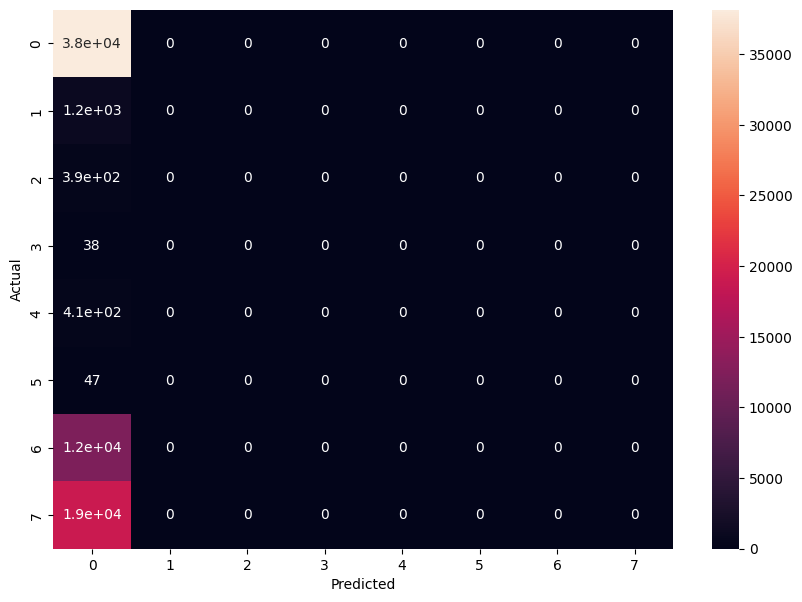

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes1)

# Visualización
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [23]:
import numpy as np 
# Tamaño del lote
batch_size = 1000

# Número de lotes
num_batches = int(np.ceil(X_test.shape[0] / float(batch_size)))

# Inicializar las predicciones
y_pred = np.zeros((X_test.shape[0], y.max()+1))

# Hacer predicciones en cada lote
for i in range(num_batches):
    start = i * batch_size
    end = min((i+1) * batch_size, X_test.shape[0])
    y_pred[start:end] = model_rnn.predict(X_test[start:end].toarray())

# Obtener las clases predichas
y_pred_classes2 = np.argmax(y_pred, axis=1)

11/11 [==============================] - 3s 257ms/step


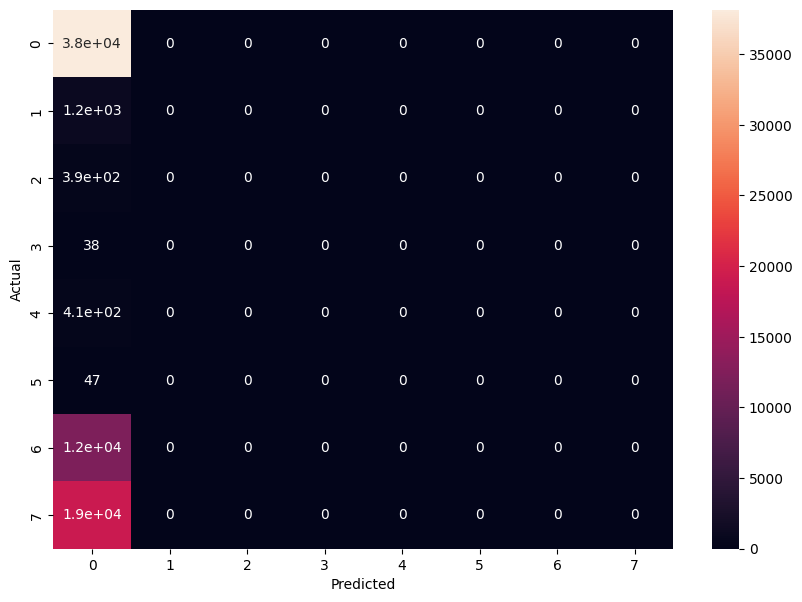

In [24]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes2)

# Visualización
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

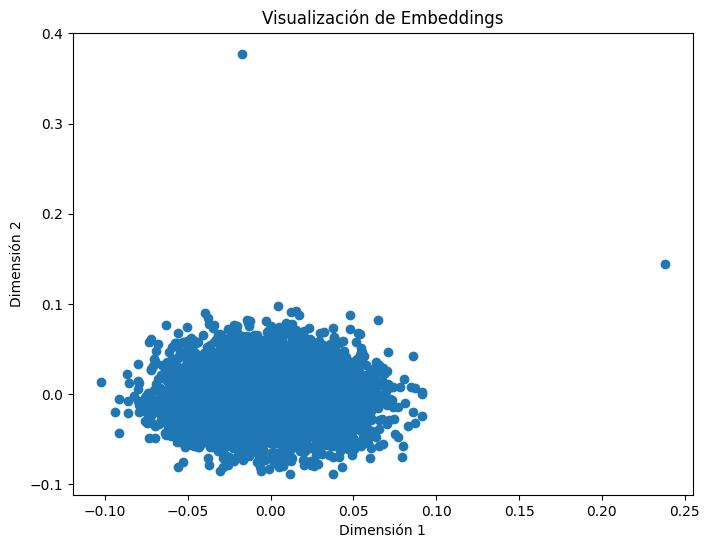

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Obtener los embeddings del modelo, asumiendo que tienes una capa de embeddings llamada 'embedding'
embeddings = model_cnn.get_layer('embedding').get_weights()[0]

# Reducir la dimensionalidad con PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Trazar los embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('Visualización de Embeddings')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()


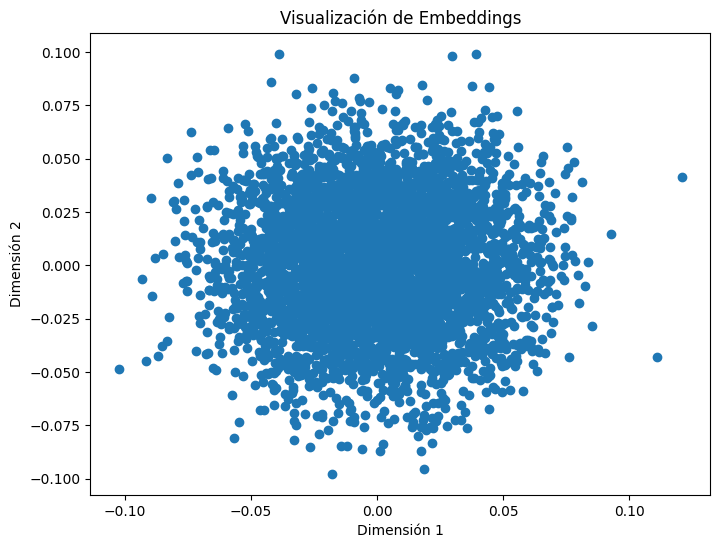

In [41]:


# Obtener los embeddings del modelo, asumiendo que tienes una capa de embeddings llamada 'embedding'
embeddings = model_rnn.get_layer('embedding_1').get_weights()[0]

# Reducir la dimensionalidad con PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Trazar los embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('Visualización de Embeddings')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()
